<a href="https://colab.research.google.com/github/j1ayizhao/datascienceA2/blob/main/JiayZhaoUnit5Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

## Context

The dataset I chose involves penguins, and the variables I chose to analyze are flipper length and body mass. The focus of my project is to analyze how flipper length predicts body mass using a generalized linear model. Later on I also filter the data by species, to analyze variations in this relationship across
species. This context would allow us to study the differences in physical relationships across penguin species and make predictions about the kinds of environmental or evolutionary factors affecting the observed differences.

In [2]:
url_penguins = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/penguins.csv'
#I could have put the url string directly into pd.read_csv()

penguins = pd.read_csv(url_penguins)
penguins = penguins.dropna()
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


## Data Visualization

The scatter plot shows a positive relationship between flipper length and body mass, which shows that this dataset is compatible with a generalized linear model

<Axes: xlabel='flipper_length', ylabel='body_mass'>

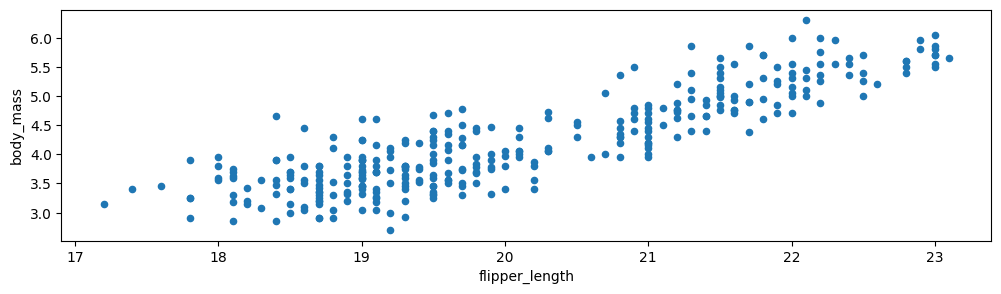

In [ ]:
#scatter plot of temperature v. rented count of bikes
penguins.plot(x="flipper_length", y="body_mass", figsize=(12, 3), kind="scatter")

## Model
With minimal prior knowledge, I used wide distributions for the intercept and standard deviation priors to let the data speak for itself.

The orange lines represent the mean of my posterior, or what the model expects the data to look like if it were truly a straight line. Since all the orange lines capture the postive, upwards relationship between flipper length and body mass and none of them have different slopes, I would say the model does a pretty good job of explaining the relationship between the two variables



In [3]:
#lba stands for linear penguins
with pm.Model() as model_lp:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * penguins.flipper_length)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=penguins.body_mass)

    idata_lp = pm.sample()

Output()

Output()

Text(0, 0.5, 'body_mass')

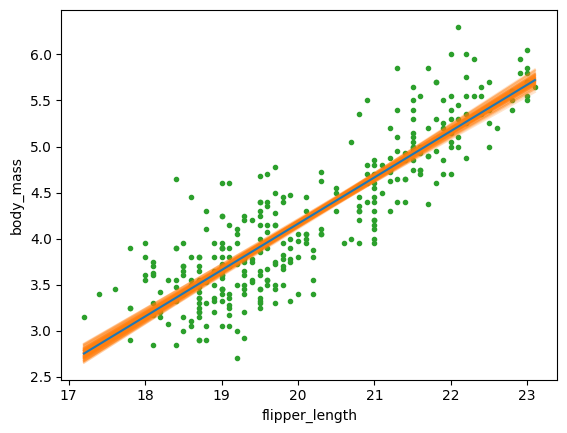

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_lp, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(penguins.flipper_length.min(), penguins.flipper_length.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(penguins.flipper_length, penguins.body_mass, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("flipper_length")
ax.set_ylabel("body_mass")

In [4]:
pm.sample_posterior_predictive(idata_lp, model=model_lp,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'body_mass')

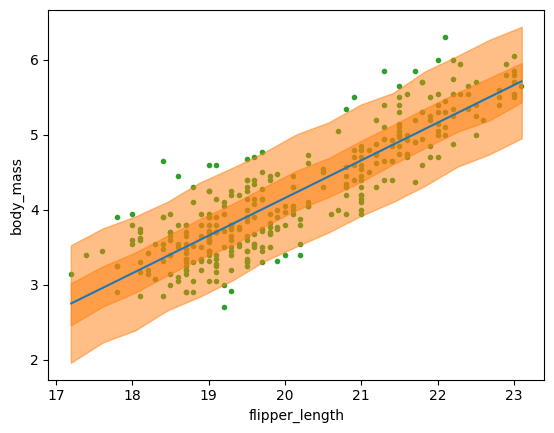

In [ ]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_lp.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
flipper_lengths = np.random.normal(penguins.flipper_length.values, 0.01)
idx = np.argsort(flipper_lengths)
x = np.linspace(flipper_lengths.min(), flipper_lengths.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_lp.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(flipper_lengths[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(penguins.flipper_length, penguins.body_mass, "C2.", zorder=-3)
ax.plot(penguins.flipper_length.to_numpy()[idx], mean_line.to_numpy()[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("flipper_length")
ax.set_ylabel("body_mass")


## Posterior predictive

The posterior predictive distribution still captures the postive linear trend, while capturing the variation in predicted body mass as seen through the orange shaded areas (corresponding to 94% and 50% HDI) which encapsulates most of the observed data, leaving out very few data points

<Axes: xlabel='y_pred'>

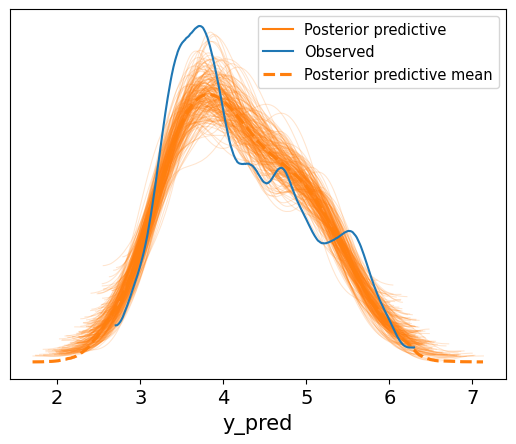

In [ ]:

#posterior predictive check
az.plot_ppc(idata_lp, num_pp_samples=200, colors=["C1", "C0", "C1"])

From the posterior predictive check, we can see that the model is pretty reliable. The orange lines, representing predictions, closely follow the shape of the observed data. This shows that the model captures not only the mean relationship but the variability in predicted body mass given flipper lengths.

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


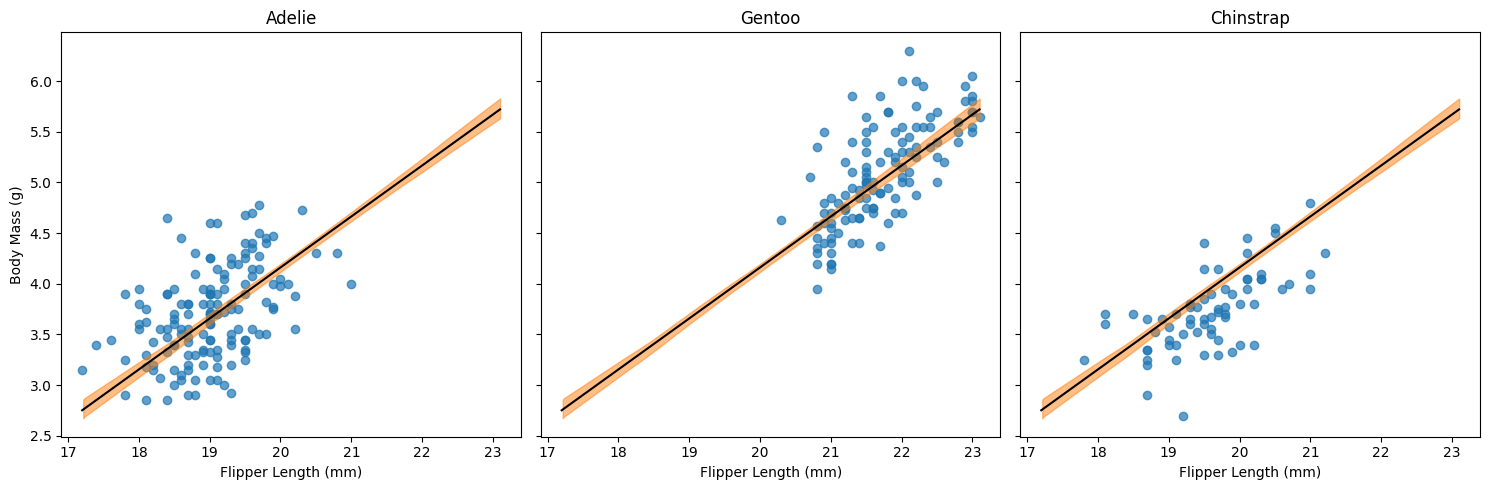

In [ ]:
# Unique penguin species
species = penguins['species'].unique()

# Set up the grid of plots
_, ax = plt.subplots(1, len(species), figsize=(15, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

# Prepare x-range for the line of best fit
x_range = np.linspace(penguins['flipper_length'].min(), penguins['flipper_length'].max(), 100)

# Loop over each species
for i, sp in enumerate(species):
    # Filter data for the species
    species_data = penguins[penguins['species'] == sp]

    # Scatter plot for the raw data
    ax[i].scatter(
        species_data['flipper_length'],
        species_data['body_mass'],
        alpha=0.7,
        label='Data'
    )

    # Title and labels
    ax[i].set_title(f"{sp}")
    ax[i].set_xlabel("Flipper Length (mm)")
    if i == 0:  # Add y-axis label only to the first subplot
        ax[i].set_ylabel("Body Mass (g)")

    # Extract posterior samples
    alphas = posterior["α"]
    betas = posterior["β"]

    # Mean line of best fit
    alpha_m = alphas.mean().item()
    beta_m = betas.mean().item()
    ax[i].plot(
        x_range,
        alpha_m + beta_m * x_range,
        color="black",
        label="Mean Line"
    )

    # 94% HDI for the line of best fit
    az.plot_hdi(
        x_range,
        alphas + betas * xr.DataArray(x_range).transpose(),
        ax=ax[i],
        fill_kwargs={"alpha": 0.5}
    )

# Adjust layout
plt.tight_layout()
plt.show()

These graphs show the flipper-length and body mass relationship across the three different penguin species in the dataset. We can see that for those attributes in all three species follow a positive linear relationship, and Gentloo penguins have the longest flipper length and biggest body mass, while Adelie and Chinstrap have similar flipper length and body mass. Additionally, the data points for Gentloo penguins are closer together, making the slope steeper and thus indicating a stronger relationship between these attributes.

This insight could help us look more into things like whether Gentloo penguins have specific ecological adaptations, diets that led them to have longer flippers, and whether the similarity between the other 2 species can attributed to shared ecological niches and things like that.
